In [1]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from copy import deepcopy

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from ripser import Rips
from persim import plot_diagrams, bottleneck

from manifold_torch import Manifold_Tabular_Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def arg_parse():
    parser = argparse.ArgumentParser(description="Persistence diagram Tabular")
    parser.add_argument(
            "--exp", dest="exp", help="Experiments"
        )
    parser.add_argument(
            "--radius", dest="radius", type=float, help="Radius of perturbation"
        )
    parser.add_argument(
        "--multiplier", dest="multiplier", type=int, help="Number of times an image is perturbed"
    )
    parser.add_argument(
        "--dim", dest="dim", type=int, help="Number of low dim"
    )
    parser.add_argument(
        "--runs", dest="runs", type=int, help="Number of runs"
    )
    parser.add_argument(
        "--target", dest="target", type=int, help="Sublabel to approximiate local hyperplane"
    )
    parser.add_argument(
        "--shuffle", dest="shuffle", type=bool, help="Shuffle the pivots"
    )
    
        
    parser.set_defaults(
        exp = 'compass',
        radius = 0.0001,
        runs = 10,
        multiplier = 1000,
        dim = 2,
        shuffle = True,
        target = None
    )
    return parser.parse_args()


In [2]:
EXPERIMENT = 'cc'
RADIUS = 0.0001
MULTIPLIER = 800
DIM = 3
SHUFFLE = False
RUNS = 1
TARGET = None

print("EXPERIMENT: ", EXPERIMENT)
print("TARGET: ", TARGET)
print("RUNS: ", RUNS)
print("RADIUS: ", RADIUS)
print("MULTIPLIER: ", MULTIPLIER)
print("DIM: ", DIM)

EXPERIMENT:  cc
TARGET:  None
RUNS:  1
RADIUS:  0.0001
MULTIPLIER:  800
DIM:  3


In [3]:
# Get the data set and do some preprocessing
params = Params("data/experiment_params.json")
np.random.seed(params.seed)
if EXPERIMENT == 'compass':
    X, y, cols = get_and_preprocess_compas_data(params)
elif EXPERIMENT == 'german':
    X, y, cols = get_and_preprocess_german(params)
elif EXPERIMENT == 'cc':
    X, y, cols = get_and_preprocess_cc(params)
else:
    print("Nothing to do.")    
    
print("Done loading")

xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.1)
ss = StandardScaler().fit(X)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)
xall = ss.transform(X)

start_time = time.time()
manifold_sampler = Manifold_Tabular_Sampler(torch.tensor(xall), dim = DIM, labels = torch.tensor(y))
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = torch.unique(torch.tensor(y))
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Done loading
Initialize duration:  11.530000925064087


In [14]:
RADIUS = 200
gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
gauss_noise = gauss_
plane_noise = np.zeros_like(gauss_noise)

for d in range(Gv.shape[0]):
    proj = np.dot(gauss_noise, Gv[d])
    for s in range(plane_noise.shape[0]):
        plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
ortho_noise = gauss_noise - plane_noise

# noise
ortho_norm = normalize(ortho_noise, RADIUS)
plane_norm = normalize(plane_noise, RADIUS)
gauss_norm = normalize(gauss_noise, RADIUS)

# point clouds
ortho_pc = manifold_sampler.pivots + ortho_norm
plane_pc = manifold_sampler.pivots + plane_norm
gauss_pc = manifold_sampler.pivots + gauss_norm

ori_pc = manifold_sampler.pivots.cpu().detach().numpy()
ortho_pc = ortho_pc.cpu().detach().numpy()
plane_pc = plane_pc.cpu().detach().numpy()
gauss_pc = gauss_pc.cpu().detach().numpy()

In [15]:
# import umap
# ori_pca = umap.UMAP()
# ortho_pca = umap.UMAP()
# plane_pca = umap.UMAP()
# gauss_pca = umap.UMAP()

In [16]:
from sklearn.decomposition import PCA

ori_pca = PCA(n_components=2)
ortho_pca = PCA(n_components=2)
plane_pca = PCA(n_components=2)
gauss_pca = PCA(n_components=2)

ori_2d = ori_pca.fit_transform(ori_pc)
ortho_2d = ortho_pca.fit_transform(ortho_pc)
plane_2d = plane_pca.fit_transform(plane_pc)
gauss_2d = gauss_pca.fit_transform(gauss_pc)

NameError: name 'ori_2d' is not defined

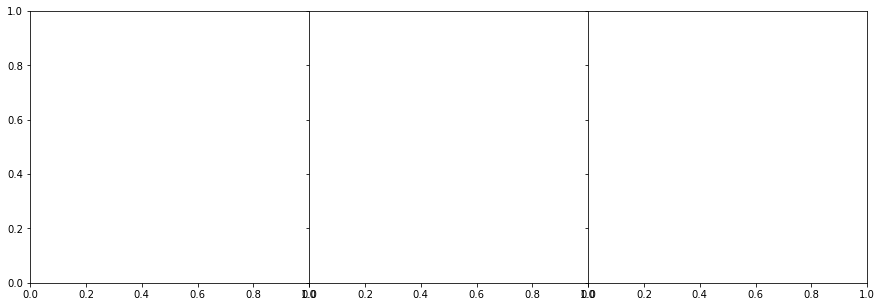

In [2]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0)
(ax1, ax2, ax3) = gs.subplots(sharex='col', sharey='row')

# fig.suptitle('PCA visualization of cc dataset and different perturbations.',fontsize=20)

# plt.figure()
# plt.figure(figsize=(15,5))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)
# plt.xlabel('Principal Component - 1',fontsize=20)
# plt.ylabel('Principal Component - 2',fontsize=20)
# plt.title("Principal Component Analysis of Compass Dataset",fontsize=20)

lo = ax1.scatter(ori_2d[0:200,0], ori_2d[0:200,1], color = 'black', s = 8)
lplane = ax1.scatter(plane_2d[0:1000,0], plane_2d[0:1000,1], color = 'r', marker='o', alpha=.2)
ax1.set_xlim([-16, 14])
ax1.set_ylim([-8, 20])
# ax1.xlim([-16, 11])
# ax1.ylim([-7, 20])
ax1.axis('off')

# ax2.figure(figsize=(5,5))
ax2.scatter(ori_2d[0:400,0], ori_2d[0:400,1], color = 'black', s = 8)
lgauss = ax2.scatter(gauss_2d[0:400,0], gauss_2d[0:400,1],  s = 50, color = 'm', marker='o', alpha=.2)
ax2.set_xlim([-16, 14])
ax2.set_ylim([-8, 20])
ax2.axis('off')

# plt.figure(figsize=(5,5))
ax3.scatter(ori_2d[0:400,0], ori_2d[0:400,1], color = 'black', s = 8)
lemap = ax3.scatter(ortho_2d[0:400,0], ortho_2d[0:400,1], s = 50, color = 'b', marker='o', alpha=.2)
ax3.set_xlim([-16, 14])
ax3.set_ylim([-8, 20])
ax3.axis('off')


# plt.scatter(plane_2d[:,0], plane_2d[:,1], color = 'b', s = 1)
# plt.scatter(gauss_2d[:,0], gauss_2d[:,1], color = 'g', s = 1)
fig.legend([lo, lplane, lgauss, lemap],["Original data", "Manifold-Projection", "Gauss", "Manifold-Orthogonal (EMaP)"], loc="lower center", ncol=4, fontsize = 15)

# plt.legend(loc="lower left", ncol=4)


In [19]:
fig.savefig("result/images/fig1.png")

In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [66]:
z.shape

(100, 100)

In [82]:
z

5.65685424949238

(-0.05500000000000001,
 0.05500000000000001,
 -20.280197708415265,
 20.416460745153948)

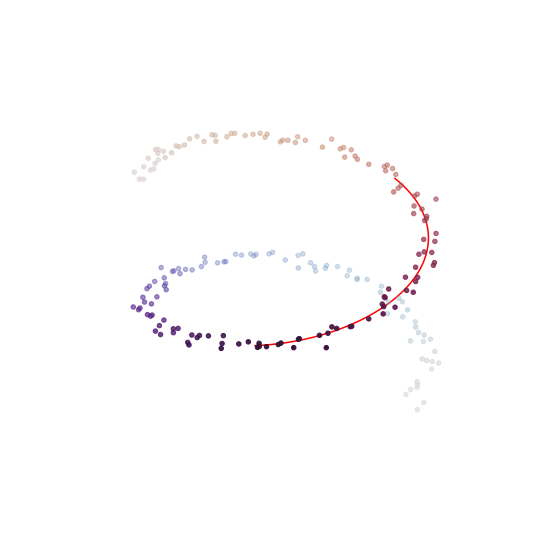

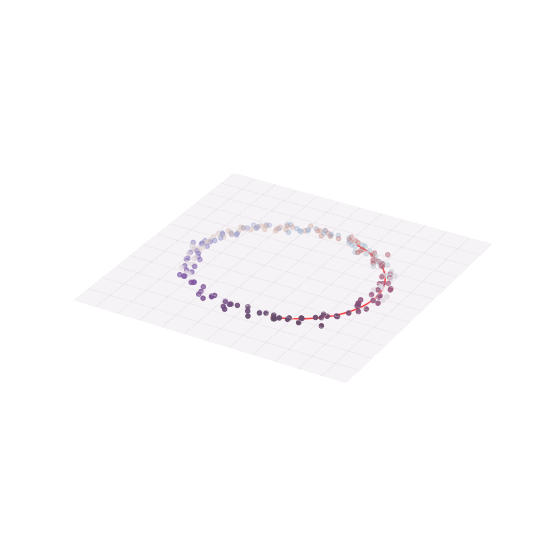

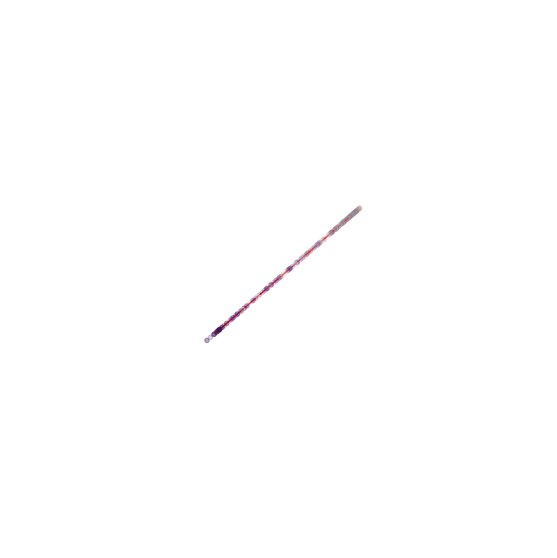

In [34]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
theta = np.linspace(0, 3.2 * np.pi, 201)
zvert = np.linspace(0, 2000, 201)
r = 20
phi = np.pi / 6 # "tilt" of the circle

# ax.plot3D(x, y, z, 'gray')
xline = r*np.cos(theta[100:150])
yline = r*np.sin(theta[100:150])*np.cos(phi)
zline = r*np.sin(theta[100:150])*np.sin(phi) + zvert[100:150]
ax.plot3D(xline, yline, zline, 'red')
xdata = r*np.cos(theta) + 1.0 * np.random.randn(201)
ydata = r*np.sin(theta)*np.cos(phi) + 1.0 * np.random.randn(201)
zdata = r*np.sin(theta)*np.sin(phi) + 1.0 * np.random.randn(201) + zvert
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='twilight');
ax.axis('off')
plt.savefig("result/spiral3d.png", transparent=True)

fig = plt.figure(figsize = (10,10))
ax_2d = plt.axes(projection='3d')
ax_2d.plot3D(xline, yline, np.zeros_like(zline), 'red')
ax_2d.scatter3D(xdata, ydata, np.zeros_like(zdata), c=zdata, cmap='twilight');
# Make data.
X = np.arange(-30, 35, 5.0)
Y = np.arange(-30, 35, 5.0)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)
# Plot the surface.
surf = ax_2d.plot_surface(X, Y, Z, cmap='twilight',
                       linewidth=0, antialiased=False, alpha=0.3,)

ax_2d.axis('off')
# plt.savefig("result/circle1d.png", transparent=True)
# ax_2d.set_zlim(- 0.001, 0.01)

# Draw plane
# fig = plt.figure(figsize = (15,15))
# ax_plane = plt.axes(projection='3d')
# # ax_2d.plot3D(xline, yline, np.zeros_like(zline), 'gray')
# surf_plane = ax_plane.plot_surface(X, Y, Z, cmap='twilight',
#                        linewidth=0, antialiased=False, alpha=0.35,)

# ax_plane.axis('off')
# # plt.savefig("result/plane2.png", transparent=True)

# Draw line
fig = plt.figure(figsize = (10,10))
ax_line = plt.axes(projection='3d')
ax_line.plot3D(np.zeros_like(xline), yline, np.zeros_like(zline), 'red')
ax_line.scatter3D(np.zeros_like(xdata), ydata, np.zeros_like(zdata), c=zdata, cmap='twilight', alpha = 0.2);

# surf_plane = ax_plane.plot_surface(X, Y, Z, cmap='twilight',
#                        linewidth=0, antialiased=False, alpha=0.35,)

ax_line.axis('off')
# plt.savefig("result/plane2.png", transparent=True)

In [26]:
yline

array([-17.32050808, -17.30128015, -17.24363905, -17.14771276,
       -17.01371426, -16.84194106, -16.63277454, -16.3866791 ,
       -16.10420113, -15.78596781, -15.4326857 , -15.04513916,
       -14.62418865, -14.17076879, -13.68588627, -13.17061767,
       -12.626107  , -12.05356321, -11.4542575 , -10.82952048,
       -10.18073921,  -9.50935415,  -8.81685595,  -8.10478213,
        -7.37471366,  -6.62827148,  -5.86711288,  -5.09292783,
        -4.3074352 ,  -3.51237899])

(-1.099996967427821,
 1.0999958153993328,
 -0.05500000000000001,
 0.05500000000000001)

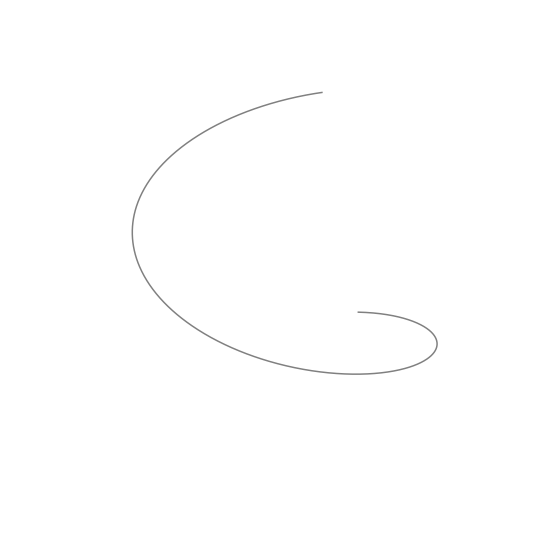

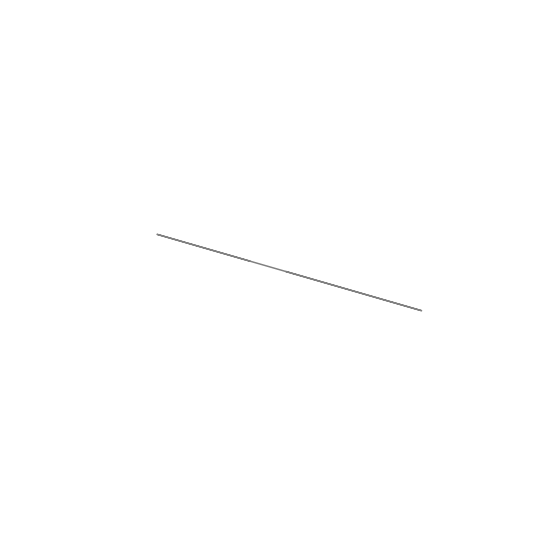

In [145]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 6, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 6 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='winter');
ax.axis('off')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.setp(ax.get_zticklabels(), visible=False)
# plt.savefig("result/topo.png")

fig = plt.figure(figsize = (10,10))
valz = 0
ax_2d = plt.axes(projection='3d')
ax_2d.plot3D(xline, np.zeros_like(yline), np.zeros_like(zline), 'gray')
# ax_2d.scatter3D(xdata, np.zeros_like(ydata), np.zeros_like(zdata), c=zdata, cmap='winter');
# plt.setp(ax_2d.get_xticklabels(), visible=False)
# plt.setp(ax_2d.get_yticklabels(), visible=False)
# plt.setp(ax_2d.get_zticklabels(), visible=False)
ax_2d.axis('off')
# plt.savefig("result/topo1d.png")

In [98]:
(ax1, ax2, ax3) = gs.subplots(sharex='col', sharey='row')

In [49]:
import umap
ori_umap = umap.UMAP(n_neighbors=10, min_dist = 0.001, random_state=42)
_ = ori_umap.fit(ori_pc)

In [50]:
ori_emb = ori_umap.transform(ori_pc)
ortho_emb = ori_umap.transform(np.concatenate((ortho_pc,ori_pc)))
plane_emb = ori_umap.transform(np.concatenate((plane_pc,ori_pc)))
gauss_emb = ori_umap.transform(np.concatenate((gauss_pc,ori_pc)))

<Figure size 432x288 with 0 Axes>

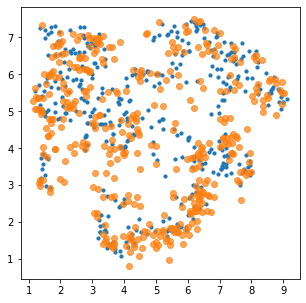

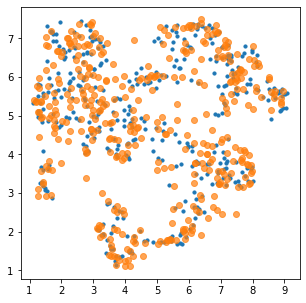

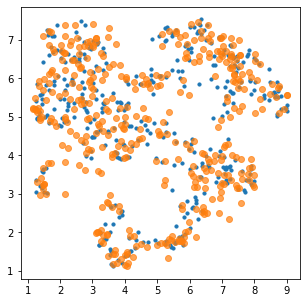

In [52]:
plt.figure()
plt.figure(figsize=(5,5))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)
# plt.xlabel('Principal Component - 1',fontsize=20)
# plt.ylabel('Principal Component - 2',fontsize=20)
# plt.title("Principal Component Analysis of Compass Dataset",fontsize=20)

plt.scatter(plane_emb[400:800,0], plane_emb[400:800,1], s = 10)
# plt.scatter(ori_emb[0:400,0], ori_emb[0:400,1], s = 10)
plt.scatter(plane_emb[0:400,0], plane_emb[0:400,1],  marker='o', alpha=.7)
# plt.xlim([-4, 6])
# plt.ylim([-4, 6])

plt.figure(figsize=(5,5))
plt.scatter(gauss_emb[400:800,0], gauss_emb[400:800,1], s = 10)
plt.scatter(gauss_emb[0:400,0], gauss_emb[0:400,1],  marker='o', alpha=.7)
# plt.xlim([-4, 6])
# plt.ylim([-4, 6])

plt.figure(figsize=(5,5))
plt.scatter(ortho_emb[400:800,0], ortho_emb[400:800,1], s = 10)
plt.scatter(ortho_emb[0:400,0], ortho_emb[0:400,1],  marker='o', alpha=.7)
# plt.xlim([-4, 6])
# plt.ylim([-4, 6])
